# Libraries

In [1]:
import os, os.path
import numpy as np
import pandas as pd
import cv2 as cv
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix,graycoprops
from skimage.feature import local_binary_pattern
from scipy.stats import entropy
from scipy.stats import skew
import scipy.stats

from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import (NeighborhoodComponentsAnalysis, KNeighborsClassifier)
from imblearn.over_sampling import RandomOverSampler

In [2]:
## Directory
def main_directory(place='local'):
    """This function is to set the path of the working place, depending if we are working online or local

    Args:
        place (str): Name of the place. Two options. Defaults to 'local'.
    """
    if (place=='local'):
        os.chdir('/Users/Usuario/Desktop/MAIA/3rd_semester/CAD/Projecte_1')
    elif (place=='online'):
        os.chdir('/content/drive/MyDrive/MAIA/3rd_semester/CAD/Projecte_1')
    else:
        print('Not accepted working place, try again')
        
    return os.getcwd()

# Set working directory
main_path = main_directory(place='local')

# Classes

In [3]:
class path_label():
    def __init__(self, meta, classif, set_name) -> None:
        meta = meta.loc[meta['classif'] == classif] #Filter by classif
        meta = meta.loc[meta['set'] == set_name] #Filter by set

        self.paths = list(meta.path)
        self.labels = np.array(meta.label)
        self.FOV_x1 = np.array(meta.FOV_x1, dtype=np.int16)
        self.FOV_x2 = np.array(meta.FOV_x2, dtype=np.int16)
        self.FOV_y1 = np.array(meta.FOV_y1, dtype=np.int16)
        self.FOV_y2 = np.array(meta.FOV_y2, dtype=np.int16)

# Functions

## Saving and loading

In [4]:
def save_pickle(file, filename):
    """save as pickle

    Args:
        file (obj): object to save
        filename (str): path of the object to save
    """
    with open(filename, 'wb') as handle:
        pickle.dump(file, handle, pickle.HIGHEST_PROTOCOL)

def open_pickle(filename):
    """open pickle file

    Args:
        filename (str): path of pickle file

    Returns:
        obj: object extracted form pickle
    """
    with open(filename, 'rb') as handle:
        return pickle.load(handle)

In [5]:
def get_glcm(im_gray):
    """
    Save the following GLCM features:
    Contrast, dissimilarity, homogeneity, energy, correlation and ASM.
    """
    
    # Quantize image to 3 bits (8 levels):
    gray_8 = (im_gray/32).astype(np.int32)
    
    # Get the co-occurrence matrix parameters:
    Glcm = graycomatrix(gray_8, distances=[1], angles=[0], levels=8)

    # Get the following statistical values of co-occurrence matrix:
    f_descr = {'contrast', 'dissimilarity','homogeneity', 'energy', 'correlation', 'ASM'}
    
    fv = []
    for prop in f_descr:
        temp = graycoprops(Glcm, prop)
        fv.append(temp)
    
    return (np.array(fv)).flatten().tolist()


def get_first_order_features(im):
    """
    Save the following 1st order texture features: 
    Min, max and mean intensites, range, std, median, skewness, kurtosis and entropy.
    """
    feats = []
    
    im_flat = im.flatten()
    
    fmin = np.min(im_flat)
    feats.extend([fmin])

    fmax = np.max(im_flat)
    feats.extend([fmax])

    fmean= np.mean(im_flat)
    feats.extend([fmean])

    fstd= np.std(im_flat)
    feats.extend([fstd])

    fmedian= np.median(im_flat)
    feats.extend([fmedian])

    skewness = scipy.stats.skew(im_flat)
    feats.extend([skewness])

    kurtosis = scipy.stats.kurtosis(im_flat)
    feats.extend([kurtosis])

    frange = fmax - fmin
    feats.extend([frange])

    entrop = scipy.stats.entropy(im_flat)
    feats.extend([entrop])
    
    return feats


def get_LBP(im_gray):
    """
    Compute the rotation invariant uniform (frequent) LBP feature of the input grayscale image.
    """
    # Compute LBP image and its histogram for the binnary pattern of each pixel's 8-neighborhood.
    lbp_feats_im = local_binary_pattern(im_gray, P=8, R=1,method='uniform')
    lbp_feats,_ = np.histogram(lbp_feats_im.ravel())
    
    # Normalize the histogram
    lbp_feats = lbp_feats/lbp_feats.sum()

    return lbp_feats.flatten().tolist()


def get_texture_features(im):
    """
    Compute and save the following texture features:
    """
    
    fv = []
    # Save first order texture features:
    first_order_feats = get_first_order_features(im)
    fv.extend(first_order_feats)
    
    # Compute the grayscale image and save GLCM features:
    im_gray = cv.cvtColor(im,cv.COLOR_BGR2GRAY)
    glcm_feats = get_glcm(im_gray)
    fv.extend(glcm_feats)
    
    # Save LBP features of the grayscale image:
    lbp_feats = get_LBP(im_gray)
    fv.extend(lbp_feats)
    
    return fv

In [6]:
def get_color_features(im):
    """
    Save the mean intensity and the variance of the histogram of each color channel of the input image.
    """
    bins = 256
    num_chs = im.shape[2]
    size = im.shape[0]*im.shape[1]
    
    fv = []
    for ch in range(0,num_chs):
        im_ch = im[:,:,ch]
        
        # Compute the histogram for each color channel of the input image:
        hist, _ = np.histogram(im_ch.ravel(), bins=bins, range=(0,bins))
        
        # Save the mean intensity and the variance in the histogram:
        fv.extend([np.argmax(hist), np.var(hist)/size])
    return fv

In [7]:
def get_features(im):
    
    #Image smoothing with a 5x5 kernel and same depth as original image
    kernel = np.ones((5,5),np.float32)/25
    im = cv.filter2D(im, ddepth= -1, kernel = kernel)

    # Features extraction
    fv = []
    fv.extend(get_color_features(im))
    fv.extend(get_texture_features(im))
    return fv

# Implementation

# Extract features (color and texture)

In [121]:

#Read metadata file
meta = pd.read_csv('data/meta_info.csv', sep='\t')

for set_name in ['val', 'train']:
    #Set situation
    classif='3_classes'
    #Define information object
    info = path_label(meta, classif, set_name)


    #Extraction settings
    im_num = len(info.paths) #number of images in folder
    fvs = []

    for i in tqdm(range(im_num)): #Go through data
        x1 = info.FOV_x1[i]
        x2 = info.FOV_x2[i]
        y1 = info.FOV_y1[i]
        y2 = info.FOV_y2[i]
        im = cv.imread(info.paths[i])[x1:x2, y1:y2] #Read image between FOV coordinates

        # Append to fvs each image's vector of color and texture features
        fv = get_features(im)
        fvs.append(fv)

    save_pickle(fvs, main_path+f'/data/features/textures/3_classes_{set_name}_36.p')


100%|██████████| 5082/5082 [39:27<00:00,  2.15it/s]  


In [112]:

#Read metadata file
meta_test = pd.read_csv('data/meta_test.csv', sep='\t')
#Set situation
classif='3_classes'; set_name='test'
#Define information object
info = path_label(meta_test, classif, set_name)

#Extraction settings
im_num = len(info.paths) #number of images in folder
fvs = []

for i in tqdm(range(im_num)): #Go through data
    x1 = info.FOV_x1[i]
    x2 = info.FOV_x2[i]
    y1 = info.FOV_y1[i]
    y2 = info.FOV_y2[i]
    im = cv.imread(info.paths[i])[x1:x2, y1:y2] #Read image between FOV coordinates

    # Append to fvs each image's vector of color and texture features
    fv = get_features(im)
    fvs.append(fv)

save_pickle(fvs, main_path+f'/data/features/test/3_classes_test_36.p')

# Train and test

In [122]:
#Read training data
X_train = open_pickle(main_path+f'/data/features/textures/3_classes_train_36.p')
y_train = path_label(meta, '3_classes', 'train').labels

#Read validation data
X_val = open_pickle(main_path+f'/data/features/textures/3_classes_val_36.p')
y_val = path_label(meta, '3_classes', 'val').labels

#Read test features
X_test = open_pickle(main_path+f'/data/features/test/3_classes_test_36.p')

In [143]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, confusion_matrix, make_scorer
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearnex import patch_sklearn

patch_sklearn()

#ML Training setting
ros = RandomOverSampler(random_state=0, sampling_strategy = {2: 1000})
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

rus = RandomUnderSampler(random_state=0, sampling_strategy = {0: 1000, 1: 1000})
X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)

kappa_scorer = make_scorer(cohen_kappa_score)

pipe_SVC = Pipeline([('scaler', StandardScaler()),('classifier', SVC())])
param_grid_SVC = {'classifier__C':[0.1, 1, 10, 100, 1000],'classifier__gamma':[1, 0.1, 0.01, 0.001, 0.0001], 'classifier__kernel':['rbf']}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
grid_SVC = GridSearchCV(pipe_SVC, param_grid_SVC, scoring=kappa_scorer, cv = cv, verbose = 3)
model_SVC = grid_SVC.fit(X_resampled, y_resampled)


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Accuracy training:               0.8756395120031484
Accuracy validation:             0.7700787401574803
Kappa training:                  0.7836032915662106
Kappa validation:                0.6015848936599957
Balanced accuracy training:      0.8177310486472152
Balanced accuracy validation:    0.6661712189372002


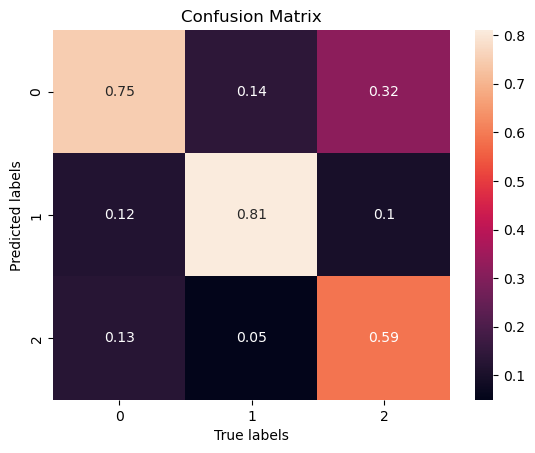

In [186]:

# Compare kappas for validation and prediction classifications:

y_pred = model.predict(X_val) #predict
acc = np.mean(y_pred == y_val) #accuracy

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
print("Accuracy training:              ", np.mean(y_pred_train==y_train))
print("Accuracy validation:            ", np.mean(y_pred_val==y_val))

kappa_train = cohen_kappa_score(y_pred_train, y_train)
kappa_val = cohen_kappa_score(y_pred_val, y_val)
print("Kappa training:                 ", kappa_train)
print("Kappa validation:               ", kappa_val)

balanced_acc_train = balanced_accuracy_score(y_pred_train, y_train)
balanced_acc_val = balanced_accuracy_score(y_pred_val, y_val)
print("Balanced accuracy training:     ", balanced_acc_train)
print("Balanced accuracy validation:   ", balanced_acc_val)

CM = confusion_matrix(y_pred_val, y_val)
CM_f = [CM[:,i]/sum(CM[:,i]) for i in range(3)]
CM_f = np.around(np.transpose(CM_f), decimals=2)

ax = plt.subplot()
sns.heatmap(CM_f, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('True labels'); ax.set_ylabel('Predicted labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['0', '1', '2']); ax.yaxis.set_ticklabels(['0', '1', '2'])
plt.show()